# LSTM과 GRU 셀

고급 순환층으로, SimpleRNN보다 계산이 훨씬 복잡하지만 성능이 뛰어나다.   
시퀀스가 길수록 순환되는 은닉 상태에 담긴 정보가 점차 희석되기 때문에 학습이 어렵다.   
멀리 떨어져 있는 단어 정보를 인식하기 위해 LSTM과 GRU 셀이 발명되었다.

In [29]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다. 
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

LSTM에는 '입력과 가중치를 곱하고 -> 절편을 더해 -> 활성화 함수를 통과'시키는 구조가 여러개 있다.   
이 계산 결과가 다음 타임스텝에 이용된다.   

LSTM에는 순환되는 상태가 2개 있는데, '은닉 상태'와 '셀 상태'가 있다.   
> '셀 상태'는 다음 층으로 저달되지 않고 LSTM 셀에서 순환만 되는 값   

1. 은닉 상태 만들기   
(1) 입력값과 (이전) 은닉 상태를 <u>가중치($w_o$)</u>에 곱한 후, sigmoid 함수를 통과시킨다.    
(2) tanh 활성화 함수를 통과한 '셀 상태'와 곱해져서 (다음) 은닉 상태를 만든다.   

2. 셀 상태 만들기     
(1) 입력값과 은닉 상태를 <u>또 다른 가중치 $w_f$</u>에 곱한 다음, sigmoid 함수를 통과시킨다.  
(2) 그 다음, 이전 셀 상태와 곱하여 <u>새로운</u> 셀 상태(초록색 순환)를 만든다. (이전 셀 상태 삭제-덮어쓰기)   
(3) tanh 함수를 통과하여 새로운 은닉 상태(분홍색 순환)를 만드는 데 기여한다.   
(4) 2개의 셀 더 추가! : 입력값과 (이전) 은닉 상태를 가중치 $w_i$와 $w_j$에 각각 곱한 다음, $w_i$는 sigmoid, $w_j$는 tanh 함수에 통과시킨다.   
(5) 두 결과를 곱한 후, 이전 셀 상태와 <u>더한다</u>. 

<img src="LSTM2.png" width=500>

## LSTM 신경망 훈련하기

In [3]:
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

# IMDB 데이터 로드
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words= 500)

train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

In [4]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 샘플 길이 맞추기
train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

In [14]:
from tensorflow import keras

model = keras.Sequential()

# 단어 임베딩 사용
model.add(keras.layers.Embedding(500, 16, input_length=100))

# LSTM 층 추가
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation='sigmoid'))

# 모델 구조 출력
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 16)           8000      
                                                                 
 lstm_2 (LSTM)               (None, 8)                 800       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,809
Trainable params: 8,809
Non-trainable params: 0
_________________________________________________________________


LSTM 셀에는 작은 셀이 4개가 있어서 SimpleRNN 클래스에 비해 4배가 늘어 파라미터 개수가 800개가 되었다.

In [15]:
# 모델 컴파일
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', 
              metrics=['accuracy'])

# 체크포인트, 조기종료 콜백 지정
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

# 모델 훈련
history = model.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 9s 23ms/step - loss: 0.6924 - accuracy: 0.5360 - val_loss: 0.6915 - val_accuracy: 0.5686
Epoch 2/100
313/313 [==============================] - 7s 22ms/step - loss: 0.6899 - accuracy: 0.6011 - val_loss: 0.6882 - val_accuracy: 0.6208
Epoch 3/100
313/313 [==============================] - 7s 22ms/step - loss: 0.6842 - accuracy: 0.6400 - val_loss: 0.6798 - val_accuracy: 0.6482
Epoch 4/100
313/313 [==============================] - 7s 23ms/step - loss: 0.6668 - accuracy: 0.6774 - val_loss: 0.6489 - val_accuracy: 0.6908
Epoch 5/100
313/313 [==============================] - 7s 23ms/step - loss: 0.5977 - accuracy: 0.7206 - val_loss: 0.5650 - val_accuracy: 0.7280
Epoch 6/100
313/313 [==============================] - 7s 23ms/step - loss: 0.5432 - accuracy: 0.7416 - val_loss: 0.5311 - val_accuracy: 0.7472
Epoch 7/100
313/313 [==============================] - 7s 23ms/step - loss: 0.5139 - accuracy: 0.7623 - val_loss: 0.5065 - val_accuracy:

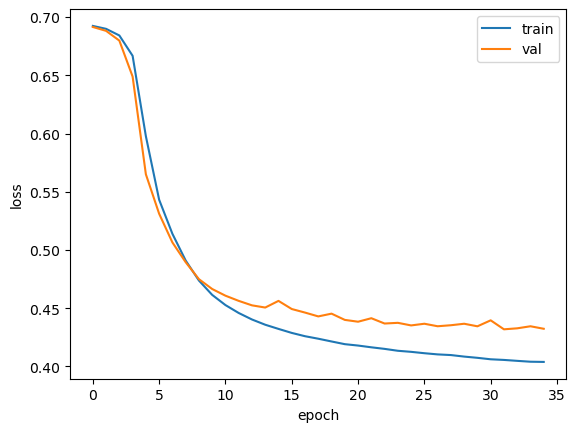

In [16]:
import matplotlib.pyplot as plt

# 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

기본 순환층보다 LSTM이 과대적합을 억제하면서 훈련을 잘 수행한 것으로 보인다.   
경우에 따라서는 과대 적합을 더 강하게 제어할 필요가 있으므로, 드롭아웃을 적용해보자.

## 순환 층에 드롭아웃 적용하기

순환층은 자체적으로 드롭아웃 기능을 제공한다.   
SimpleRNN과 LSTM 클래스 모두 dropout 매개변수과 recurrent_dropout 매개변수를 가지고 있다.   
* dropout : 셀의 입력에 드롭아웃 적용    
* recurrent_dropout : 순환되는 은닉 상태에 드롭아웃 적용 - GPU를 사용하지 못한다는 단점이 있다(훈련 속도 느려짐).

In [17]:
model2 = keras.Sequential()

model2.add(keras.layers.Embedding(500, 16, input_length=100))
# LSTM 층에 dropout=0.3 매개변수 추가
model2.add(keras.layers.LSTM(8, dropout=0.3))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

In [18]:
# 모델 컴파일
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', 
               metrics=['accuracy'])

# 체크포인트, 조기종료 콜백 지정
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-dropout-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

# 모델 훈련
history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 9s 24ms/step - loss: 0.6930 - accuracy: 0.5168 - val_loss: 0.6927 - val_accuracy: 0.5336
Epoch 2/100
313/313 [==============================] - 7s 23ms/step - loss: 0.6923 - accuracy: 0.5555 - val_loss: 0.6919 - val_accuracy: 0.5666
Epoch 3/100
313/313 [==============================] - 7s 23ms/step - loss: 0.6907 - accuracy: 0.5982 - val_loss: 0.6894 - val_accuracy: 0.6006
Epoch 4/100
313/313 [==============================] - 7s 23ms/step - loss: 0.6820 - accuracy: 0.6202 - val_loss: 0.6677 - val_accuracy: 0.6162
Epoch 5/100
313/313 [==============================] - 7s 23ms/step - loss: 0.6374 - accuracy: 0.6777 - val_loss: 0.6235 - val_accuracy: 0.6936
Epoch 6/100
313/313 [==============================] - 7s 23ms/step - loss: 0.6107 - accuracy: 0.7015 - val_loss: 0.6003 - val_accuracy: 0.7158
Epoch 7/100
313/313 [==============================] - 7s 23ms/step - loss: 0.5887 - accuracy: 0.7196 - val_loss: 0.5797 - val_accuracy:

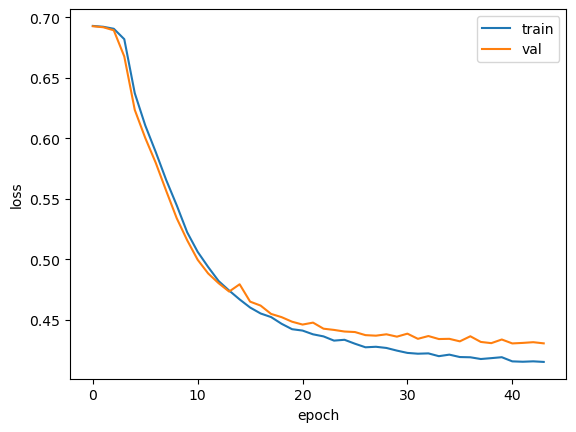

In [19]:
# 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

드롭아웃을 적용한 결과, 훈련 손실과 검증 손실 간의 차이가 좁혀진 것을 확인할 수 있다.

## 2개의 층을 연결하기

* 순환층을 연결할 때 주의할 점:    
순환층의 은닉 상태는 샘플의 마지막 타임스텝에 대한 은닉 상태만 다음 층으로 전달한다.   
순환층을 쌓게 되면 모든 순환층에 순차 데이터가 필요하다.   
(마지막 은닉 상태만 받을거면 순환층 하나를 2배로 돌리면 되지 층 쌓을 필요가 없어지..니까?)   
> 마지막 이전의 순환층은 모든 타임스텝에 대한 은닉 상태를 출력해야 한다.   
> 마지막 순환층만 마지막 타임스텝의 은닉 상태를 출력해야 한다.

이를 위해서는 마지막을 제외한 모든 순환층에 return_sequences=True 지정해야 한다.   
(상상만 해도 오래 걸리겠는데....)

In [20]:
model3 = keras.Sequential()

model3.add(keras.layers.Embedding(500, 16, input_length=100))
# 마지막을 제외한 '순환층'에 return_sequences=True 추가
model3.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))
model3.add(keras.layers.LSTM(8, dropout=0.3))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 16)           8000      
                                                                 
 lstm_4 (LSTM)               (None, 100, 8)            800       
                                                                 
 lstm_5 (LSTM)               (None, 8)                 544       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9,353
Trainable params: 9,353
Non-trainable params: 0
_________________________________________________________________


첫번째 LSTM 층이 모든 타임스텝(100개)의 은닉 상태를 출력하기 때문에 출력 크기가 (None, 100, 8)이다.   
두번째 LSTM 층은 마지막 타임스텝의 은닉 상태만 출력하기 때문에 (None, 8)이다.

In [21]:
# 2개의 순환층이 있어서 더 느리다
# 모델 컴파일
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model3.compile(optimizer=rmsprop, loss='binary_crossentropy', 
               metrics=['accuracy'])

# 체크포인트, 조기 종료 콜백 설정
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-2rnn-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

# 모델 훈련
history = model3.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 17s 45ms/step - loss: 0.6928 - accuracy: 0.5234 - val_loss: 0.6925 - val_accuracy: 0.5594
Epoch 2/100
313/313 [==============================] - 14s 43ms/step - loss: 0.6919 - accuracy: 0.5645 - val_loss: 0.6912 - val_accuracy: 0.6004
Epoch 3/100
313/313 [==============================] - 14s 45ms/step - loss: 0.6890 - accuracy: 0.6150 - val_loss: 0.6861 - val_accuracy: 0.6372
Epoch 4/100
313/313 [==============================] - 14s 46ms/step - loss: 0.6746 - accuracy: 0.6562 - val_loss: 0.6531 - val_accuracy: 0.6856
Epoch 5/100
313/313 [==============================] - 14s 45ms/step - loss: 0.6127 - accuracy: 0.6949 - val_loss: 0.5839 - val_accuracy: 0.7032
Epoch 6/100
313/313 [==============================] - 15s 48ms/step - loss: 0.5663 - accuracy: 0.7228 - val_loss: 0.5468 - val_accuracy: 0.7342
Epoch 7/100
313/313 [==============================] - 14s 44ms/step - loss: 0.5364 - accuracy: 0.7453 - val_loss: 0.5238 - val_ac

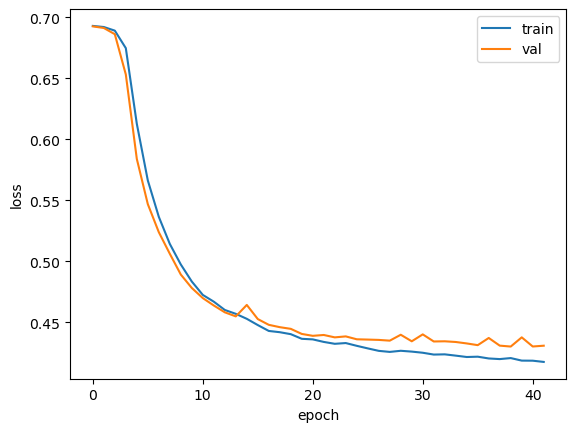

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

일반적으로 순환층을 쌓으면 성능이 높아지지만, 이 예제에서는 그리 큰 효과를 내지는 못했다.   
그래프를 보면, 과대적합을 제어하면서 손실을 최대한 낮춘것을 확인할 수 있다.

## GRU 신경망 훈련하기
GRU(Gated Recurrent Unit) : LSTM을 간소화한 버전   
셀 상태를 계산하지 않고, 은닉 상태 하나만 포함하고 있다.   

**삭제 게이트**: <u>$w_z$ 가중치를 사용한 셀의 출력</u>이 sigmoid 함수를 통과해 은닉상태에 바로 곱한다.   
**입력 정보 제어**: 1에서 <u>$w_z$ 가중치를 사용한 셀의 출력</u>을 뺀 값을 <u>$w_g$ 가중치를 사용한 셀의 출력</u>에 곱한다.   
**은닉 상태 정보 제어**: <u>$w_r$ 가중치를 사용한 셀의 출력</u>은 <u>$w_g$ 가중치에 입력될 은닉 상태 정보를 제어</u>한다.

<img src="GRU.PNG" width=500>

In [23]:
model4 = keras.Sequential()

model4.add(keras.layers.Embedding(500, 16, input_length=100))
# GRU 클래스를 사용한 것 외에 이전 모델과 동일
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation='sigmoid'))

model4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 16)           8000      
                                                                 
 gru (GRU)                   (None, 8)                 624       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,633
Trainable params: 8,633
Non-trainable params: 0
_________________________________________________________________


GRU 층의 모델 파라미터 개수를 계산하면,   
- 입력에 곱하는 가중치는 16 * 8 = 128개,   
- 은닉 상태에 곱하는 가중치는 8 * 8 = 64개,   
- 절편은 뉴런마다 하나씩 8개,   
- 모두 더하면 128 + 64 + 8 = 200개,   
- 작은 셀이 3개가 포함되어 있으므로, 모두 600개 모델 파라미터가 필요하다.   

은닉 상태가 먼저 가중치 $w_h$와 곱해진 다음 G 세의 출력과 곱해진다.   
이 때문에 은닉 상태에 곱해지는 가중치 외에 별도의 절편이 필요하다.   
작은 셀마다 절편이 추가 -> 3 * 8 = 24개의 모델 파라미터가 추가된다.   

즉, 최종적으로 모델 파라미터의 개수는 624개   

<img src="GRU2.PNG" width=500>

In [24]:
# 모델 컴파일
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model4.compile(optimizer=rmsprop, loss='binary_crossentropy', 
               metrics=['accuracy'])

# 체크포인트, 조기 종료 콜백
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

# 모델 훈련
history = model4.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 10s 27ms/step - loss: 0.6923 - accuracy: 0.5281 - val_loss: 0.6916 - val_accuracy: 0.5380
Epoch 2/100
313/313 [==============================] - 8s 26ms/step - loss: 0.6901 - accuracy: 0.5652 - val_loss: 0.6892 - val_accuracy: 0.5622
Epoch 3/100
313/313 [==============================] - 8s 25ms/step - loss: 0.6869 - accuracy: 0.5853 - val_loss: 0.6856 - val_accuracy: 0.5762
Epoch 4/100
313/313 [==============================] - 8s 26ms/step - loss: 0.6818 - accuracy: 0.6039 - val_loss: 0.6795 - val_accuracy: 0.6010
Epoch 5/100
313/313 [==============================] - 8s 26ms/step - loss: 0.6733 - accuracy: 0.6215 - val_loss: 0.6692 - val_accuracy: 0.6258
Epoch 6/100
313/313 [==============================] - 8s 26ms/step - loss: 0.6584 - accuracy: 0.6447 - val_loss: 0.6498 - val_accuracy: 0.6556
Epoch 7/100
313/313 [==============================] - 8s 26ms/step - loss: 0.6285 - accuracy: 0.6765 - val_loss: 0.6069 - val_accuracy

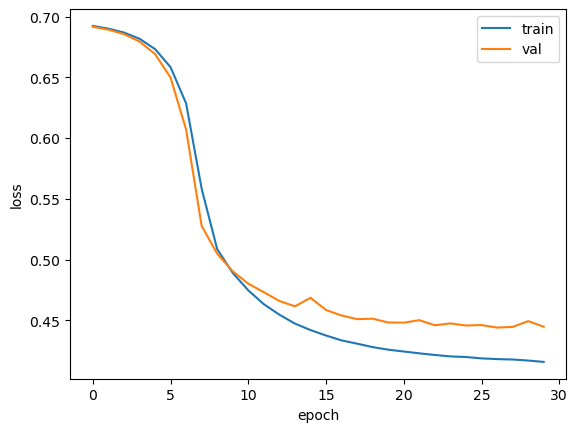

In [25]:
# 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

**메모리를 효율적으로 사용**하면서 LSTM와 거의 비슷한 성능을 내는 것을 확인할 수 있다.   
(드롭아웃을 사용하지 않았기 때문에 훈련 손실과 검증 손실 간에 차이가 있다.)   
~~드롭아웃 사용하면 성능이 떨어질 수 있나?~~

In [26]:
# 레이어 2층 쌓고 + 드롭아웃 적용하면 어떨까해서 추가로 돌려본 것 ###########
model5 = keras.Sequential()

model5.add(keras.layers.Embedding(500, 16, input_length=100))
model5.add(keras.layers.GRU(8, dropout=0.3, return_sequences=True))
model5.add(keras.layers.GRU(8, dropout=0.3))
model5.add(keras.layers.Dense(1, activation='sigmoid'))

model5.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 16)           8000      
                                                                 
 gru_1 (GRU)                 (None, 100, 8)            624       
                                                                 
 gru_2 (GRU)                 (None, 8)                 432       
                                                                 
 dense_6 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9,065
Trainable params: 9,065
Non-trainable params: 0
_________________________________________________________________


In [27]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model5.compile(optimizer=rmsprop, loss='binary_crossentropy', 
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model5.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 18s 50ms/step - loss: 0.6922 - accuracy: 0.5340 - val_loss: 0.6915 - val_accuracy: 0.5600
Epoch 2/100
313/313 [==============================] - 15s 49ms/step - loss: 0.6900 - accuracy: 0.5730 - val_loss: 0.6888 - val_accuracy: 0.5912
Epoch 3/100
313/313 [==============================] - 15s 49ms/step - loss: 0.6856 - accuracy: 0.5999 - val_loss: 0.6831 - val_accuracy: 0.6076
Epoch 4/100
313/313 [==============================] - 15s 49ms/step - loss: 0.6769 - accuracy: 0.6176 - val_loss: 0.6716 - val_accuracy: 0.6250
Epoch 5/100
313/313 [==============================] - 15s 48ms/step - loss: 0.6602 - accuracy: 0.6342 - val_loss: 0.6512 - val_accuracy: 0.6422
Epoch 6/100
313/313 [==============================] - 15s 48ms/step - loss: 0.6340 - accuracy: 0.6535 - val_loss: 0.6201 - val_accuracy: 0.6610
Epoch 7/100
313/313 [==============================] - 15s 49ms/step - loss: 0.6021 - accuracy: 0.6737 - val_loss: 0.5889 - val_ac

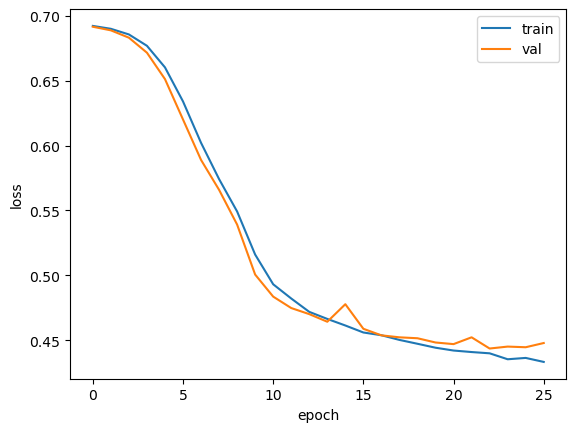

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

과대적합이 잘 억제된 것을 확인함. = 드롭아웃의 효과.   
성능이 높아지진 않았다.   

## 마무리

가장 좋은 결과값을 보였던 2개의 순환층을 쌓은 모델을 다시 로드하여 테스트 세트에 대한 성능을 확인해보자.   

In [30]:
# 테스트 세트를 훈련세트와 동일한 방식으로 변환 (길이를 100으로 패딩)
test_seq = pad_sequences(test_input, maxlen=100)

# 2개 순환층을 가진 베스트 모델 불러오기
rnn_model = keras.models.load_model('best-2rnn-model.h5')

# evaluate() 메서드로 테스트 세트에서의 성능 확인
rnn_model.evaluate(test_seq, test_target)

782/782 [==============================] - 9s 11ms/step - loss: 0.4255 - accuracy: 0.8015


[0.42554888129234314, 0.8014799952507019]

드롭아웃을 적용하여 과대적합을 잘 억제했기 때문에 테스트 세트의 성능이 검증 세트와 크게 차이가 나지 않는다.